In [1]:
import numpy as np
import pandas as pd
import scipy.stats as ss
import cryptofxns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
filename = '/Users/croth/Downloads/xl280genome.fasta'
#filename = '/Users/croth/Desktop/R1_PM/scripts/crypto-qtls/2016-05/Cryptococcus_neoformans_JEC21.genome.fa'

results = []
with open(filename) as inputfile:
    for line in inputfile:
        results.append(line.strip().split(' '))
inputfile.close()

chrin = []
chroms = []
for ln,line in enumerate(results):
    if line[0].startswith('>'): ## Start of each chromosome beginning with 14
        chrin.append(ln)
        chroms.append(line[0])

clens = cryptofxns.chromosome_lengths;
assert len(chrin) == len(clens)

chrin  = chrin + [-1];print chrin

chrsequs = [[] for ch in clens ]

order = [int(a[-2:]) -1 for a in chroms];print order

for i, o in enumerate(order):
    chrsequs[o] = ''.join(list(np.concatenate(results[chrin[i]+1:chrin[i+1]])))

for ch,chrm in enumerate(chrsequs):
    print len(chrm) - clens[ch]

[0, 38344, 56441, 73440, 88553, 101687, 114400, 141606, 176703, 206422, 231549, 255533, 277997, 297904, -1]
[0, 9, 10, 11, 12, 13, 1, 2, 3, 4, 5, 6, 7, 8]
0
0
0
1
0
0
0
0
-2
0
0
0
0
0


In [3]:
fileend = '-min-Geno-k6000.csv'

In [4]:
IMIdf = pd.read_csv('../FILES/Crypto-Genome-IMIxCO%s'%fileend).reset_index(drop=True)

In [5]:
IMIdf.shape

(82961, 8)

In [6]:
IMIdf.head()

,Chrom,W,V,IMI,XO,uXO,bXO,Pos
0,Chr01,5016.0,5299.0,282,0.0,0.0,0.0,5157.5
1,Chr01,5299.0,5464.0,164,0.0,0.0,0.0,5381.5
2,Chr01,5464.0,6120.0,655,0.0,0.0,0.0,5792.0
3,Chr01,6120.0,6166.0,45,0.0,0.0,0.0,6143.0
4,Chr01,6166.0,6477.0,310,0.0,0.0,0.0,6321.5


In [7]:
IMIdf.uXO.sum() + IMIdf.bXO.sum()

3297.0

In [8]:
chrlist = IMIdf.Chrom.unique().tolist();len(chrlist)

14

## Load in Hot spot and Cold spot index info

In [9]:
ws = 41500
hot_spot_index = pd.read_table('../FILES/Crypto-Hot-Spots-Index-%s-min-Geno-k6000.csv'%str(ws),header=None);
cold_spot_index = pd.read_table('../FILES/Crypto-Cold-Spots-Index-%s-min-Geno-k6000.csv'%str(ws),header=None);

In [10]:
hot_spot_index.ix[0,0].split('r')

['Ch', '01']

In [11]:
hot_index_temp = []
for i in hot_spot_index.index.tolist():
     if hot_spot_index.ix[i,0].split('r') != 'Ch':
        hot_index_temp.append([int(a) for a in hot_spot_index.ix[i,0].split(',')[:-1]])
hot_index = [a for a in hot_index_temp if len(a) > 0]       

In [12]:
len(hot_index) 

35

In [13]:
cold_index_temp = []
for i in cold_spot_index.index.tolist():
    if cold_spot_index.ix[i,0].split('r') != 'Ch':
        cold_index_temp.append([int(a) for a in cold_spot_index.ix[i,0].split(',')[:-1]])
cold_index = [a for a in cold_index_temp if len(a) > 0]

In [14]:
len(cold_index)

54

## check work

In [16]:
print IMIdf.ix[hot_index[-1]].Chrom.unique().tolist() ## Should be Chr14
print IMIdf.ix[hot_index[-1]][IMIdf.XO>0].XO.sum() ## Should be 33
for hotin in hot_index:
    assert IMIdf.ix[hotin].XO.sum() > 0
for coldin in cold_index:
    assert 0==IMIdf.ix[coldin].XO.sum() ## Should be 0

['Chr14']
33.0


/Users/croth/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


In [22]:
hotIMIdf = IMIdf.ix[np.unique(np.concatenate(hot_index))][IMIdf.XO>=0].copy() ## Take unique and above zero for IMI with co
coldIMIdf = IMIdf.ix[np.unique(np.concatenate(cold_index))][IMIdf.XO==0].copy() ## Make sure they are zero! 

/Users/croth/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
/Users/croth/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


In [23]:
otherIMIindex = [a for a in IMIdf.index.tolist() 
                 if a not in np.concatenate(hot_index).tolist() + np.concatenate(cold_index).tolist()]

In [24]:
len(hotIMIdf)

7558

In [25]:
len(coldIMIdf)

7369

In [26]:
print len(otherIMIindex)
otherIMIdf = IMIdf.ix[otherIMIindex].copy()

68051


In [27]:
len(otherIMIdf.Chrom.unique().tolist())

14

In [28]:
len(hotIMIdf.Chrom.unique().tolist()) ## Should be 14, with 41500 window we see hot spots on all chroms

14

In [29]:
len(coldIMIdf.Chrom.unique().tolist()) ## Should be 14 too

14

## Chose IMI that are not hotspots

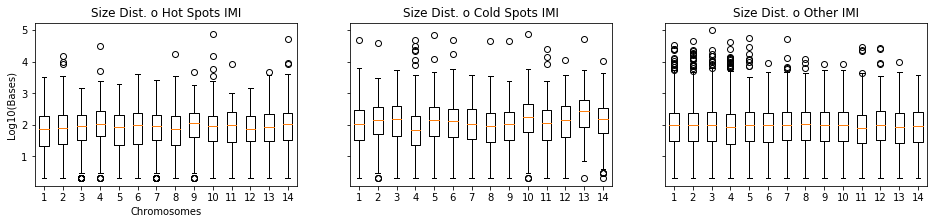

In [30]:
fig,(ax0,ax1,ax2) = plt.subplots(1,3,figsize=(16,3),sharex=True,sharey=True)
plt.sca(ax0)
plt.boxplot([np.log10(hotIMIdf[hotIMIdf.Chrom == chrom].IMI.values) for chrom in chrlist]);
plt.title('Size Dist. o Hot Spots IMI');
plt.xlabel('Chromosomes');plt.ylabel('Log10(Bases)');
plt.sca(ax1)
plt.boxplot([np.log10(coldIMIdf[coldIMIdf.Chrom == chrom].IMI.values) for chrom in chrlist]);
plt.title('Size Dist. o Cold Spots IMI');
plt.sca(ax2)
plt.boxplot([np.log10(otherIMIdf[otherIMIdf.Chrom==chrom].IMI.values) for chrom in chrlist]);
plt.title('Size Dist. o Other IMI');

In [31]:
def find_IMIsequence(df,chrlist,genome_seq):
    hotsequences = []
    for ch,chrom in enumerate(chrlist):
        sub = df[df.Chrom == chrom];
        if len(sub) == 0:
            continue
        for i in sub.index.tolist():
            w = int(sub.ix[i,'W']);
            v = int(sub.ix[i,'V']);
            hotsequences.append(genome_seq[ch][w:v+1])
    return hotsequences

In [32]:
notseqall = find_IMIsequence(otherIMIdf,chrlist,chrsequs)
hotseqall = find_IMIsequence(hotIMIdf,chrlist,chrsequs)
coldseqall = find_IMIsequence(coldIMIdf,chrlist,chrsequs)

In [33]:
Minhot = min([len(seq) for seq in hotseqall]);print("Hot",Minhot)
Mincold = min([len(seq) for seq in coldseqall]);print('Cold',Mincold)
Minother = min([len(seq) for seq in notseqall]);print("Other",Minother)

('Hot', 4)
('Cold', 4)
('Other', 4)


In [34]:
Maxhot = max([len(seq) for seq in hotseqall]); print(Maxhot)
Maxcold = max([len(seq) for seq in coldseqall]); print(Maxcold)
Maxhother = max([len(seq) for seq in notseqall]); print (Maxhother)

73949
73949
98818


In [35]:
def num_nuclio(seq): 
    A = 0;T = 0;G=0;C=0
    for n in seq:
        if n in ['A','R','W','M','D','H','V','N']: ## From http://www.bioinformatics.org/sms/iupac.html
            A = A + 1
        elif n in ['T','Y','W','K','B','D','H','N']:
            T = T + 1
        elif n in ['G','R','K','B','D','V','N']:
            G = G + 1
        elif n in ['C','Y','S','M','B','H','V','N']:
            C = C + 1
        else:
            print('error',n)
    return A,T,G,C

def GC_content(seq):
    A,T,G,C = num_nuclio(seq)
    return (G + C)/float(A + T + G + C)

def AT_GC_ratio(seq):
    A,T,G,C = num_nuclio(seq)
    return (A+T)/float(G + C)

def sequence_GC_AT_GC_ratio(sequences):
    GC_cont = [];
    AT_GC_r =[];
    for seq in sequences:
        try:
            GC_cont.append(GC_content(seq))
            AT_GC_r.append(AT_GC_ratio(seq))
        except ZeroDivisionError:
            pass
    return GC_cont,AT_GC_r

In [36]:
#"".join(kf_notspots.SEQ.tolist())
len("".join(notseqall[:5]))

1385

In [37]:
len(hotseqall)

7558

In [38]:
len(coldseqall)

7369

sample = 200;
hot_GC_cont_sampling = []
cold_GC_cont_sampling = []
not_GC_cont_sampling = []
for i in range(1000):
    notseq_sample = [notseqall[a] for a in np.random.choice(len(notseqall),sample)]
    hotseq_sample = [hotseqall[a] for a in np.random.choice(len(hotseqall),sample)]
    coldseq_sample = [coldseqall[a] for a in np.random.choice(len(coldseqall),sample)]
    not_GC_cont,not_AT_GC = sequence_GC_AT_GC_ratio(notseq_sample)
    hot_GC_cont,hot_AT_GC = sequence_GC_AT_GC_ratio(hotseq_sample)
    cold_GC_cont,cold_AT_GC = sequence_GC_AT_GC_ratio(coldseq_sample)
    hot_GC_cont_sampling.append(np.mean(hot_GC_cont));
    cold_GC_cont_sampling.append(np.mean(cold_GC_cont));
    not_GC_cont_sampling.append(np.mean(not_GC_cont));

In [39]:
not_GC_cont,not_AT_GC = sequence_GC_AT_GC_ratio(notseqall)
hot_GC_cont,hot_AT_GC = sequence_GC_AT_GC_ratio(hotseqall)
cold_GC_cont,cold_AT_GC = sequence_GC_AT_GC_ratio(coldseqall)

In [40]:
genom_gc_content_mean = 0.486

fig, ax = plt.subplots(1,1,figsize = (6,3))
plt.hist(hot_GC_cont_sampling,alpha=.5,color='r');
plt.hist(cold_GC_cont_sampling,alpha=.5,color='b');
plt.hist(not_GC_cont_sampling,alpha=.3,color='g');
plt.vlines(genom_gc_content_mean,0,50,'yellow',label='Mean Genome (0.486)');
plt.vlines(np.mean(hot_GC_cont_sampling),0,50,'red');
plt.vlines(np.mean(cold_GC_cont_sampling),0,50,'blue');
plt.vlines(np.mean(not_GC_cont_sampling),0,50,'green');
#plt.title('Sampling Distributions of the Mean\n G-C Content\nHot Spots vs Cold Spots\n & Genomic Background',
#         fontsize=18);
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["top"].set_visible(False)
plt.xlabel('Mean G-C Content',fontsize=16);
plt.ylabel('Counts',fontsize=16);
plt.tight_layout();
plt.savefig('../FIGS/Crypto-Hot-Spot-G-C-Sampling-Mean.png',dpi=600);

In [41]:
import seaborn as sns

In [42]:
sns.set()

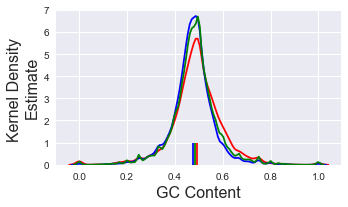

In [43]:
fig, ax = plt.subplots(1,1,figsize = (5,3))
sns.kdeplot(hot_GC_cont,color='r')
sns.kdeplot(cold_GC_cont,color='b')
sns.kdeplot(not_GC_cont,color='g')
plt.vlines(genom_gc_content_mean,0,1,'yellow',label='Mean Genome (0.486)');
plt.vlines(np.mean(hot_GC_cont),0,1,'red');
plt.vlines(np.mean(cold_GC_cont),0,1,'blue');
plt.vlines(np.mean(not_GC_cont),0,1,'green');
#plt.title('Sampling Distributions of the Mean\n G-C Content\nHot Spots vs Cold Spots\n & Genomic Background',
#         fontsize=18);
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["top"].set_visible(False)
plt.xlabel('GC Content',fontsize=16);
plt.ylabel('Kernel Density \nEstimate',fontsize=16);
plt.tight_layout();
plt.ylim(0,7);
plt.savefig('../FIGS/Crypto-Hot-Spot-G-C-Distributions-%s-Sep2017.png'%ws,dpi=600);

In [38]:
len(hot_GC_cont)

584

In [51]:
print np.mean(hot_GC_cont)
print np.mean(cold_GC_cont)
print np.mean(not_GC_cont)
print genom_gc_content_mean

0.491141229489
0.475007127137
0.482953364527
0.486


In [52]:
z = 1.96
print np.mean(hot_GC_cont) + z*ss.sem(hot_GC_cont)
print np.mean(hot_GC_cont) - z*ss.sem(hot_GC_cont)

0.493573377263
0.488709081715


In [53]:
z = 1.96
print np.mean(cold_GC_cont) + z*ss.sem(cold_GC_cont)
print np.mean(cold_GC_cont) - z*ss.sem(cold_GC_cont)

0.477015959528
0.472998294746


In [54]:
z = 1.96
print np.mean(not_GC_cont) + z*ss.sem(not_GC_cont)
print np.mean(not_GC_cont) - z*ss.sem(not_GC_cont)

0.483685655058
0.482221073997


In [55]:
ss.ttest_ind(hot_GC_cont,cold_GC_cont)

Ttest_indResult(statistic=9.9992410755885324, pvalue=1.8203243304793044e-23)

In [57]:
ss.normaltest(hot_GC_cont)

NormaltestResult(statistic=760.17409370762186, pvalue=8.5171227908294908e-166)

In [58]:
ss.normaltest(cold_GC_cont)

NormaltestResult(statistic=758.65106724851898, pvalue=1.8239540870430334e-165)

In [94]:
def bootstrap_ci(x,p=1000,c=[25,975]):
    diffs = sorted([np.mean(x) - np.mean(np.random.choice(x,len(x),replace=True)) for i in range(p)])
    return np.mean(x)-abs(diffs[24]),np.mean(x),np.mean(x)+abs(diffs[974])

In [99]:
genom_gc_content_mean

0.486

In [101]:
len(not_GC_cont)

68051

In [106]:
GC_cont_df = pd.DataFrame([hot_GC_cont,cold_GC_cont,not_GC_cont],index=['Hot','Cold','Other']).T

In [107]:
GC_cont_df.shape

(68051, 3)

In [109]:
GC_cont_df.to_csv('../FILES/Crypto-GC-content-Nov2017.csv',index=False);

In [100]:
not_GC_ci = bootstrap_ci(not_GC_cont);print not_GC_ci

(0.4822489104361154, 0.48295336452746029, 0.48365043997242158)


In [95]:
hot_gc_ci = bootstrap_ci(hot_GC_cont);

In [96]:
hot_gc_ci

(0.48869679727552046, 0.49114122948926286, 0.49355131011859432)

In [97]:
cold_gc_ci = bootstrap_ci(cold_GC_cont)

In [98]:
cold_gc_ci

(0.47293334126579351, 0.47500712713709842, 0.47689807657039812)

In [119]:
?sns.kdeplot

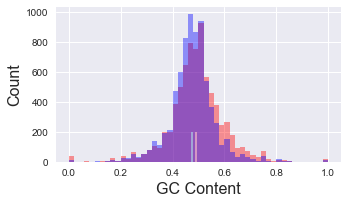

In [124]:
fig, ax = plt.subplots(1,1,figsize = (5,3))
sns.distplot(hot_GC_cont,color='r',kde=False)
sns.distplot(cold_GC_cont,color='b',kde=False)
#sns.kdeplot(not_GC_cont,color='g')
plt.vlines(genom_gc_content_mean,0,1,'yellow',label='Mean Genome (0.486)');
plt.vlines(np.mean(hot_GC_cont),0,200,'pink',alpha=.7);
plt.vlines(np.mean(cold_GC_cont),0,200,'lightblue',alpha=.7);
#plt.vlines(np.mean(not_GC_cont),0,1,'green');
#plt.title('Sampling Distributions of the Mean\n G-C Content\nHot Spots vs Cold Spots\n & Genomic Background',
#         fontsize=18);
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["top"].set_visible(False)
plt.xlabel('GC Content',fontsize=16);
plt.ylabel('Count',fontsize=16);
plt.tight_layout();
#plt.ylim(0,7);
plt.savefig('../FIGS/Crypto-Hot-Spot-G-C-Distributions-%s-Sep2017.png'%ws,dpi=600);

#### print np.mean(hot_GC_cont_sampling) + z*ss.sem(hot_GC_cont_sampling)
print np.mean(hot_GC_cont_sampling) - z*ss.sem(hot_GC_cont_sampling)

In [46]:
np.mean(cold_GC_cont)

0.47500712713709842

In [47]:
np.mean(hot_GC_cont)

0.49114122948926286

In [41]:
ss.ks_2samp(cold_GC_cont,not_GC_cont)

Ks_2sampResult(statistic=0.050462881248218294, pvalue=3.5525067290491694e-15)

In [49]:
ss.mannwhitneyu(hot_GC_cont,cold_GC_cont)

MannwhitneyuResult(statistic=24530609.0, pvalue=1.0337438097588349e-36)

In [43]:
ss.mannwhitneyu(cold_GC_cont,not_GC_cont)

MannwhitneyuResult(statistic=236465374.5, pvalue=4.5798480055667106e-16)

In [45]:
ss.ttest_1samp(cold_GC_cont,genom_gc_content_mean)

Ttest_1sampResult(statistic=-10.725648844178831, pvalue=1.2124395537487395e-26)

In [44]:
ss.ttest_1samp(hot_GC_cont,genom_gc_content_mean)

Ttest_1sampResult(statistic=4.1431733326662235, pvalue=3.4626803528896568e-05)

In [ ]:
assert 1 == 2 ## November 13

## Find where these sequences over lap

In [45]:
filename_gtf = '/Users/croth/Desktop/R1_PM/scripts/crypto-qtls/2016-05/Cryptococcus_neoformans_JEC21.gtf'

In [46]:
gtf_lines = []
with open(filename_gtf) as inputfile:
    for line in inputfile:
        gtf_lines.append(line.strip().split('\t'))
inputfile.close()

In [47]:
len(gtf_lines)

116102

In [48]:
len(gtf_lines[5])

9

In [49]:
line_size = []
for line in gtf_lines:
    line_size.append(len(line))

In [50]:
np.unique(line_size)

array([1, 9])

In [51]:
gtf_df = pd.DataFrame(gtf_lines[5:],columns=['Chrom','ENA','Type','W','V','sph','spl','spk','Info',])

In [52]:
gtf_df.head()

,Chrom,ENA,Type,W,V,sph,spl,spk,Info
0,Chr01,ENA,gene,4713,6181,.,+,.,"gene_id ""CNA00010""; gene_source ""ENA""; gene_bi..."
1,Chr01,ENA,transcript,4713,6181,.,+,.,"gene_id ""CNA00010""; transcript_id ""AAW41410""; ..."
2,Chr01,ENA,exon,4713,5053,.,+,.,"gene_id ""CNA00010""; transcript_id ""AAW41410""; ..."
3,Chr01,ENA,CDS,4713,5053,.,+,0,"gene_id ""CNA00010""; transcript_id ""AAW41410""; ..."
4,Chr01,ENA,start_codon,4713,4715,.,+,0,"gene_id ""CNA00010""; transcript_id ""AAW41410""; ..."


In [53]:
gtf_df['W'] = [int(a) for a in gtf_df['W']]

In [54]:
gtf_df['V'] = [int(a) for a in gtf_df['V']]

In [55]:
len(gtf_df[gtf_df['Chrom']=='Chr01'])

14452

In [56]:
len(gtf_df[gtf_df['W'] >= 3])

116093

In [57]:
type(gtf_df['W'][0])

numpy.int64

In [58]:
gtf_df[(gtf_df['Chrom'] == 'Chr01') & (gtf_df['W'] >= 4713) & (gtf_df['V']<= 6000)].index.tolist()

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [59]:
def annotation_overlaps(gtfdf,IMIdf):
    overlaps = []
    for i in IMIdf.index.tolist():
        overlaps.append(gtfdf[(gtfdf['Chrom'] == IMIdf.ix[i,'Chrom'])&
                              (gtfdf['W'] >= IMIdf.ix[i,'W']) & 
                              (gtfdf['V'] <= IMIdf.ix[i,'V'])].index.tolist())
    return overlaps

def make_overlaps_df(IMIDF,overlaps,gtfdf):
    a = 0
    IMIdf = IMIDF.copy()
    IMIdf['Overlap'] = 0*np.array(range(len(IMIdf)))
    for i ,overl in enumerate(overlaps):
        if len(overl) == 0:
            a = a + 1
            A = ['intergenic_region']
        else:
            A = [ gtfdf.ix[ove,'Info'] for ove in overl ]
        IMIdf['Overlap'][i] = A
    return IMIdf,a

In [60]:
hotIMIdf.IMI.max()

17921

In [61]:
len(hotIMIdf.Chrom[(hotIMIdf.IMI>100) & ( hotIMIdf.IMI < 10000)])

483

In [62]:
len(otherIMIdf[(otherIMIdf.IMI>100) & (otherIMIdf.IMI < 10000)])

32924

In [63]:
hotIMIdf.IMI[hotIMIdf.IMI>500].min()

501

In [64]:
hot_overlaps = annotation_overlaps(gtf_df,hotIMIdf);print len(hot_overlaps)

584


In [65]:
cold_overlaps = annotation_overlaps(gtf_df,coldIMIdf);print len(cold_overlaps)

7369


In [66]:
#other_overlaps = annotation_overlaps(gtf_df,otherIMIdf);print len(other_overlaps)

In [67]:
hot_overlaps_df, hota = make_overlaps_df(hotIMIdf,hot_overlaps,gtf_df)

/Users/croth/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [68]:
cold_overlaps_df,colda = make_overlaps_df(coldIMIdf,cold_overlaps,gtf_df)

/Users/croth/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/croth/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [69]:
(hota)/float(len(hot_overlaps_df))*100

64.38356164383562

In [70]:
(colda)/float(len(cold_overlaps_df))*100

78.49097570905144

In [71]:
hotIMIlist = hotIMIdf.IMI.tolist()
for i,seq in enumerate(hotseqall):
    assert len("".join(seq)) == int(hotIMIlist[i]) + 2

In [72]:
hotIMIdf.reset_index(drop=True,inplace=True)
otherIMIdf.reset_index(drop=True,inplace=True)

## Pick hot spot sequences with desired length and randomly

In [73]:
p1 = 100
p2 = 10000
N = 100
picked_hotIMIdf_index = hotIMIdf[(hotIMIdf.IMI>p1) & ( hotIMIdf.IMI<p2)].index.tolist()
random_picked_hotIMIdf_index = np.random.choice(picked_hotIMIdf_index,N,replace=False);

In [74]:
picked_hotIMIdf = hotIMIdf.ix[random_picked_hotIMIdf_index,:];
len(picked_hotIMIdf)

100

In [75]:
picked_hotIMIseq = [hotseqall[i] for i in random_picked_hotIMIdf_index]

In [76]:
picked_hotIMIlist = picked_hotIMIdf.IMI.tolist()
for i,seq in enumerate(picked_hotIMIseq):
    assert len("".join(seq)) == int(picked_hotIMIlist[i]) + 2

## pick other sequences with the specific lengths and randomly

In [77]:
picked_otherIMIdf_index = otherIMIdf[(otherIMIdf.IMI>p1)&(otherIMIdf.IMI<p2)].index.tolist()

In [78]:
len(picked_otherIMIdf_index)

32924

In [79]:
random_picked_otherIMIdf_index = np.random.choice(picked_otherIMIdf_index,N,replace=False);

In [80]:
rpoIMIlist = otherIMIdf.ix[random_picked_otherIMIdf_index,'IMI'].tolist();

In [81]:
picked_rpoIMIseq = [notseqall[i] for i in random_picked_otherIMIdf_index]

In [82]:
rpoIMIdf = otherIMIdf.ix[random_picked_otherIMIdf_index,:]

In [83]:
for i,seq in enumerate(picked_rpoIMIseq):
    assert len("".join(seq)) == int(rpoIMIlist[i]) + 2

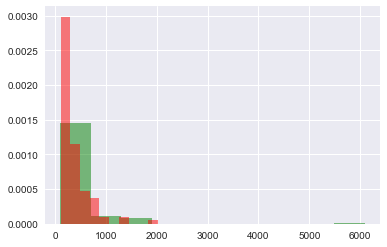

In [84]:
plt.hist(rpoIMIdf.IMI.tolist(),color='g',alpha=.5,normed=True);
plt.hist(picked_hotIMIdf.IMI.tolist(),color='r',alpha=.5,normed=True);

In [85]:
len(rpoIMIdf)

100

In [86]:
len(picked_hotIMIdf)

100

# Write sequences to FASTA format

In [87]:
## Import needed modules. 
#from __future__ import print_function
import os
from os import listdir
from os.path import isfile, join

In [92]:
hotseq_fasta_file = '../FILES/Crypto-Shared-Hotsequences-Sep2017.txt'## Name file
f = open(hotseq_fasta_file,'w')## Open file
for a,seq in enumerate(picked_hotIMIseq):## for each sequence print the sequence id and sequence to file
    fastaid = '_'.join([str(d) for d in picked_hotIMIdf[['Chrom','W','V']].values[a]]+[str(a)]) ## Name id
    f.write('>'+fastaid+'\n')
    f.write(seq+'\n')
    f.write('\n')
f.close() ## Close file.

In [93]:
memelim = 60000
a = 0;
for seq in picked_hotIMIseq:
    a = a + len("".join(seq));
print a;assert a < memelim

37445


In [94]:
othseq_fasta_file = '../FILES/Crypto-Shared-othersequences-Sep2017.txt'## Name file
f = open(othseq_fasta_file,'w')## Open file
for a,seq in enumerate(picked_rpoIMIseq):## for each sequence print the sequence id and sequence to file
    fastaid = '_'.join([str(d) for d in rpoIMIdf[['Chrom','W','V']].values[a]]+[str(a)]) ## Name id
    f.write('>'+fastaid+'\n')
    f.write(seq+'\n')
    f.write('\n')
    #print('>'+fastaid,file=f) ## print id
    #print(seq,file=f) ## print sequence 
    #print(' ',file=f) ## add a space to make look ncie 
f.close() ## Close file.

In [95]:
a = 0;
for seq in picked_rpoIMIseq:
    a = a + len("".join(seq));
print a;assert a < memelim

44737


# Submit these files to http://meme-suite.org/tools/meme


## Notes on MEME submission

#### April 12th 2017
Normal Mode,
DNA,
search for 3 motifs 

#### June 6th 2017 (THIS DIDN'T WORK)
Discriminative Mode,
DNA,
search for 3 motifs 

### July 8th 2017 (Server Error). 
Discriminative Mode,
DNA,
Any Number of Repetitions,
search for 4 motifs,

### July 10th 2017
Discriminative Mode,
DNA,
one occurance
search for 4 motifs,	
crypto-july10-hot-spot-seq-meme-search

### July 10th 2017 (Error occured)
Discriminative Mode,
DNA,
Any number of reps,
search for 4 motifs,

crypto-july10-hot-spot-seq-meme-search-any-num
##### Error message: -mod anr (-mod tcm) not yet supported for with -psp.

# Sep 10th 2017 
Discrimiinative Mode, DNA, one occurance search for 4 motifs
